In [60]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit

# Project 4: Chromatography

In this project, several different data sources are provided: Three reference measurements and one unknown sample. We need to fit Gaussian curves to the reference data, in order to make a calibration line, to determine the Methanol content of the unknown sample. As a bonus, the unknown sample has some impurities, so we need to make a multi-peak fit for that case.

Let's begin by importing and plotting the reference data:

In [61]:
time1, I1 = np.loadtxt('chrom1.csv',skiprows=1,delimiter=',',unpack=True)
time2, I2 = np.loadtxt('chrom2.csv',skiprows=1,delimiter=',',unpack=True)
time3, I3 = np.loadtxt('chrom3.csv',skiprows=1,delimiter=',',unpack=True)

time_unk, I_unk = np.loadtxt('distillate.csv',skiprows=1,delimiter=',',unpack=True)

times = np.array([time1, time2, time3])
intensities = np.array([I1,I2,I3])

# We also define an array of reference concentrations:
ref_conc = np.array([10.,18.,27.])

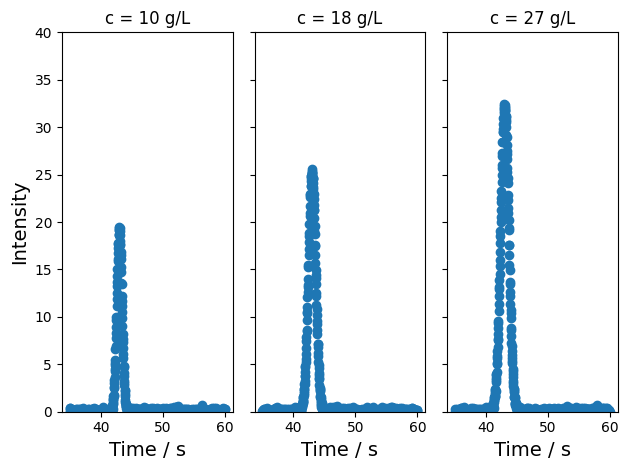

In [62]:
# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# Plot left plot
ax1.scatter(time1, I1)
ax1.set_ylabel('Intensity',fontsize=14)
ax1.set_xlabel('Time / s',fontsize=14)
ax1.set_title('c = 10 g/L')

# Plot center plot
ax2.scatter(time2, I2)
ax2.set_xlabel('Time / s',fontsize=14)
ax2.set_title('c = 18 g/L')

# Plot center plot
ax3.scatter(time3, I3)
ax3.set_xlabel('Time / s',fontsize=14)
ax3.set_title('c = 27 g/L')


# Set limits
#ax2.set_xlim([0,10.5])
ax1.set_ylim([0,40])
#ax2.set_ylim([0,100])

fig.tight_layout()

# Now we can save the figure as a .png 
#plt.savefig('concentration_time_subplots.png')
plt.show()

Now we can fit Gaussians to this data and calculate the integrals. We can use the known retention time of methanol as an initial guess. This is a repetitive task, but easily automized in python:

In [63]:
def gauss(x,A,mu_A,sig_A):
    return A*np.exp(-(x-mu_A)**2/sig_A**2)

mus    = []
sigmas = []
As     = []
integrals = []

for i in range(3):
    popt, pcov = curve_fit(gauss, times[i], intensities[i], 
                       p0=(10.,43,1.0))
    A, mu, sigma = popt
    integrals.append(np.sqrt(2*np.pi)*sigma*A)
    As.append(A)
    mus.append(mu)
    sigmas.append(sigma)
    print(A, mu, sigma)
integrals = np.array(integrals)

19.19512164732339 42.998718759828414 0.5913451401684549
25.29123249415032 43.000181727676306 0.8227276286379248
32.275378909660446 43.000378922103636 0.9188333301557169


Let's see how the fits look in the plot:

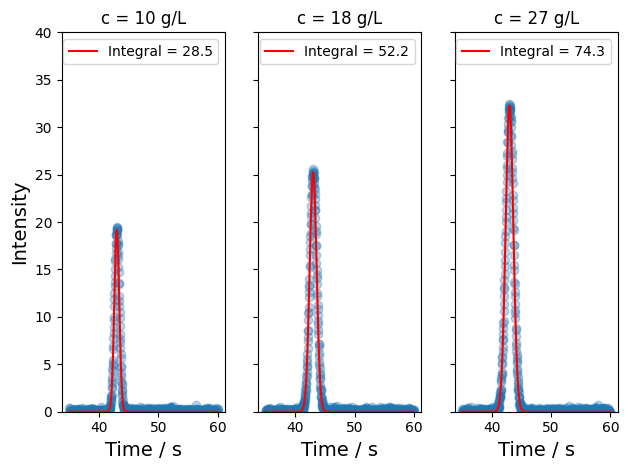

In [64]:
# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# Plot left plot
ax1.scatter(time1, I1,alpha=0.3)
ax1.plot(time1,gauss(time1,As[0],mus[0],sigmas[0]),c='r',label=f'Integral = {integrals[0]:4.1f}')
ax1.set_ylabel('Intensity',fontsize=14)
ax1.set_xlabel('Time / s',fontsize=14)
ax1.set_title('c = 10 g/L')
ax1.legend()

# Plot center plot
ax2.scatter(time2, I2,alpha=0.3)
ax2.plot(time1,gauss(time1,As[1],mus[1],sigmas[1]),c='r',label=f'Integral = {integrals[1]:4.1f}')
ax2.set_xlabel('Time / s',fontsize=14)
ax2.set_title('c = 18 g/L')
ax2.legend()

# Plot center plot
ax3.scatter(time3, I3,alpha=0.3)
ax3.plot(time1,gauss(time1,As[2],mus[2],sigmas[2]),c='r',label=f'Integral = {integrals[2]:4.1f}')
ax3.set_xlabel('Time / s',fontsize=14)
ax3.set_title('c = 27 g/L')
ax3.legend()


# Set limits
ax1.set_ylim([0,40])
#ax1.set_ylim([0,1])
#ax2.set_ylim([0,100])

fig.tight_layout()

# Now we can save the figure as a .png 
#plt.savefig('concentration_time_subplots.png')
plt.show()


From this data we can construct the calibration line:

0.37012768084115494 -0.7832434295211037


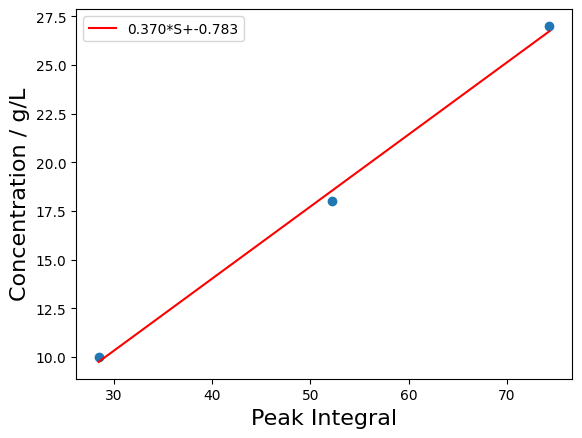

In [65]:
results = sp.stats.linregress(integrals,ref_conc)
print(results.slope,results.intercept)

plt.scatter(integrals,ref_conc)
plt.plot(integrals,results.slope*integrals + results.intercept,color='r',label=f'{results.slope:5.3f}*S+{results.intercept:5.3f}')

#plt.xticks([1.00e-05, 3.25e-05, 5.50e-05, 7.75e-05, 1.00e-04],['0.01', '0.033', '0.055', '0.078', '0.1'])

plt.ylabel('Concentration / g/L',fontsize=16)
plt.xlabel('Peak Integral',fontsize=16)

plt.legend()

#plt.xlim([0,0.08])
#plt.ylim([0,25])

plt.show()

Now we can look at the data for the unknown substance:

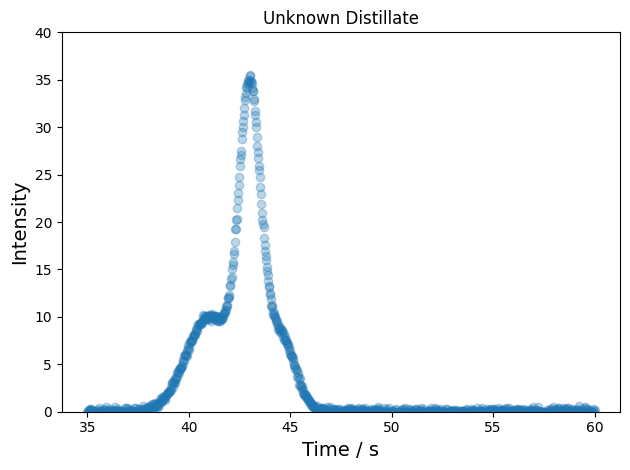

In [66]:
# Create three subplots 
fig, (ax1) = plt.subplots(1, 1, sharey=True)

# Plot left plot
ax1.scatter(time_unk, I_unk,alpha=0.3)
#ax1.plot(time1,gauss(time1,As[0],mus[0],sigmas[0]),c='r',label=f'Integral = {integrals[0]:4.1f}')
ax1.set_ylabel('Intensity',fontsize=14)
ax1.set_xlabel('Time / s',fontsize=14)
ax1.set_title('Unknown Distillate')
#ax1.legend()


# Set limits
ax1.set_ylim([0,40])
#ax1.set_ylim([0,1])
#ax2.set_ylim([0,100])

fig.tight_layout()

# Now we can save the figure as a .png 
#plt.savefig('concentration_time_subplots.png')
plt.show()

We can see that the methanol signal is mixed with two impurities here. We can use a multi peak fit to deconvolute these signals:

In [67]:
def gauss_3(x,A,B,C,mu_A,mu_B,mu_C,sig_A,sig_B,sig_C):
    return (A*np.exp(-(x-mu_A)**2/sig_A**2) + 
            B*np.exp(-(x-mu_B)**2/sig_B**2) +
            C*np.exp(-(x-mu_C)**2/sig_C**2))

popt, pcov = curve_fit(gauss_3, time_unk, I_unk, 
                       p0=(0.33,0.33,0.33,40,43,45,1.0,1.0,1.0))

A,B,C,mu_A,mu_B,mu_C,sig_A,sig_B,sig_C = popt

print(f"---Relative Components:")
print(f"A = {A:5.3f} \nB = {B:5.3f} \nC = {C:5.3f}")
print(f"---Means:")
print(f"mu_A = {mu_A:5.3f} s \nmu_B = {mu_B:5.3f} s \nmu_C = {mu_C:5.3f} s")
print(f"---Std Devs:")
print(f"sig_A = {sig_A:5.3f} s \nsig_B = {sig_B:5.3f} s \nsig_C = {sig_C:5.3f} s")



---Relative Components:
A = 32.184 
B = 10.048 
C = 8.005
---Means:
mu_A = 42.999 s 
mu_B = 41.003 s 
mu_C = 44.495 s
---Std Devs:
sig_A = 0.759 s 
sig_B = 1.604 s 
sig_C = 1.010 s


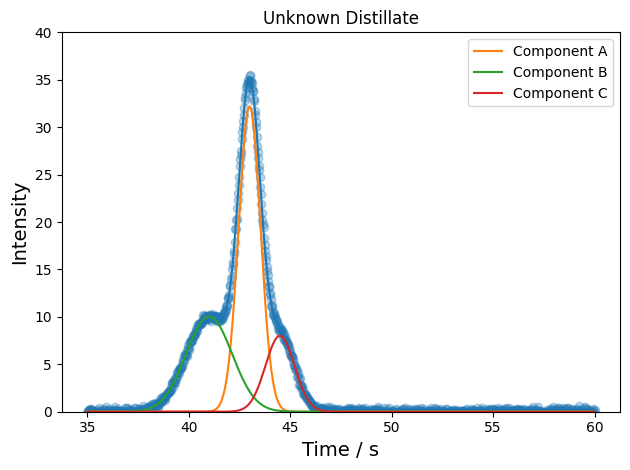

In [68]:
# Create three subplots 
fig, (ax1) = plt.subplots(1, 1, sharey=True)

# Plot left plot
ax1.scatter(time_unk, I_unk,alpha=0.3)
ax1.plot(time_unk,gauss_3(time_unk,A,B,C,mu_A,mu_B,mu_C,sig_A,sig_B,sig_C))
ax1.plot(time_unk,gauss(time_unk,A,mu_A,sig_A),label='Component A')
ax1.plot(time_unk,gauss(time_unk,B,mu_B,sig_B),label='Component B')
ax1.plot(time_unk,gauss(time_unk,C,mu_C,sig_C),label='Component C')

#ax1.plot(time1,gauss(time1,As[0],mus[0],sigmas[0]),c='r',label=f'Integral = {integrals[0]:4.1f}')
ax1.set_ylabel('Intensity',fontsize=14)
ax1.set_xlabel('Time / s',fontsize=14)
ax1.set_title('Unknown Distillate')
ax1.legend()


# Set limits
ax1.set_ylim([0,40])
#ax1.set_ylim([0,1])
#ax2.set_ylim([0,100])

fig.tight_layout()

# Now we can save the figure as a .png 
#plt.savefig('concentration_time_subplots.png')
plt.show()

From this we can finally compute the integral of the methanol component (A) and determine the concentration via our calibration line:


In [69]:
integral_unk = np.sqrt(2*np.pi)*sig_A*A
concentration_unk = results.slope*integral_unk + results.intercept
print(f"Peak Integral = {integral_unk:5.3f}, Concentration = {concentration_unk:5.3f} g/L")

Peak Integral = 61.244, Concentration = 21.885 g/L


In [70]:
plt.scatter(integrals,ref_conc)
plt.plot(integrals,results.slope*integrals + results.intercept,color='r',label=f'{results.slope:5.3f}*S+{results.intercept:5.3f}')
plt.scatter(integral_unk,concentration_unk,label='Unknown Sample')

#plt.xticks([1.00e-05, 3.25e-05, 5.50e-05, 7.75e-05, 1.00e-04],['0.01', '0.033', '0.055', '0.078', '0.1'])

plt.ylabel('Concentration / g/L',fontsize=16)
plt.xlabel('Peak Integral',fontsize=16)

plt.legend()

#plt.xlim([0,0.08])
#plt.ylim([0,25])

plt.show()